# An√°lise de S√©ries Temporais com m√©todos estat√≠sticos

## √çndices

1. **Introdu√ß√£o**
1. **Leitura e tratamento**
1. **An√°lise Explorat√≥ria**
1. **Transforma√ß√µes**
1. **Predi√ß√£o**
1. **Revers√µes**
1. **Compara√ß√µes e avali√ß√µes**
    - **Conclus√£o**

## introdu√ß√£o

O presente trabalho tem como objetivo estabelecer uma linha de base (baseline) por meio da aplica√ß√£o de m√©todos estat√≠sticos, visando fornecer um ponto de refer√™ncia para futuras compara√ß√µes. Essa baseline servir√° como fundamento para avaliar e comparar de forma objetiva os resultados obtidos com diferentes configura√ß√µes ao longo do desenvolvimento do projeto, particularmente no contexto da Neuro-Evolu√ß√£o.

**dataSet**
-   Obtido a partir do site <a href="https://gml.noaa.gov/">gml.noaa.gov</a>

**dados**
-   Os dados analisados s√£o referentes √†s <a href="https://gml.noaa.gov/ccgg/trends/gl_data.html">Tend√™ncias do di√≥xido de carbono atmosf√©rico</a>, cobrindo o per√≠odo de 1979 √† 2024.
-   As medi√ß√µes est√£o na escala de partes por milh√£o (ppm). Por exemplo, uma concentra√ß√£o de 0,000400 corresponde a 400 ppm.
    -   **Mais especificamente:** a medi√ß√£o representa uma fra√ß√£o molar de CO‚ÇÇ no ar seco, ou seja, o n√∫mero de mol√©culas de di√≥xido de carbono dividido pelo n√∫mero total de mol√©culas no ar (incluindo o pr√≥prio CO‚ÇÇ), ap√≥s a remo√ß√£o do vapor d‚Äô√°gua.

### Download e importa√ß√£o de bibliotecas

In [452]:
# pip install pandas numpy scipy matplotlib seaborn statsmodels pmdarima arch scikit-learn

In [453]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import pmdarima as pm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import f1_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from pmdarima import model_selection
from arch import arch_model
from scipy.stats import boxcox
from scipy.special import boxcox, inv_boxcox
from scipy.stats import shapiro
from scipy.stats import zscore

## Leitura e Tratamento<a id="pre_processamento"></a>

In [454]:
def ler_csv(caminho_arquivo:str, average_only:bool=False):
    # Leitura do arquivo adaptado (remo√ß√£o de coment√°rios)
    dataSet = pd.read_csv(caminho_arquivo)
    
    # Remove coluna 'decimal' se existir
    if 'decimal' in dataSet.columns:
        dataSet = dataSet.drop(columns=['decimal'])
    
    # Formata√ß√£o da coluna de data
    dataSet['data'] = pd.to_datetime(dataSet['year'].astype(str) + '-' + dataSet['month'].astype(str))
    
    if average_only:
        # Mant√©m apenas 'data' e 'average'
        dataSet = dataSet.set_index('data')['average']
    else:
        # Remove 'year' e 'month', mantendo todas as outras colunas exceto essas
        colunas = ['data'] + [col for col in dataSet.columns if col not in ['data', 'year', 'month']]
        dataSet = dataSet[colunas]
    
    return dataSet

full_data_set = ler_csv('dataSet.csv')
data_set = ler_csv('dataSet.csv', average_only=True)

In [455]:
full_data_set

data  average  average_unc   trend  trend_unc
0   1979-01-01   336.56         0.11  335.92       0.10
1   1979-02-01   337.29         0.09  336.26       0.10
2   1979-03-01   337.88         0.11  336.51       0.10
3   1979-04-01   338.32         0.13  336.72       0.11
4   1979-05-01   338.26         0.04  336.71       0.11
..         ...      ...          ...     ...        ...
547 2024-08-01   420.19         0.10  423.08       0.06
548 2024-09-01   420.50         0.10  423.35       0.06
549 2024-10-01   422.32         0.10  423.81       0.06
550 2024-11-01   424.07         0.10  424.16       0.06
551 2024-12-01   425.19         0.10  424.50       0.06

[552 rows x 5 columns]

In [456]:
full_data_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 552 entries, 0 to 551
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   data         552 non-null    datetime64[ns]
 1   average      552 non-null    float64       
 2   average_unc  552 non-null    float64       
 3   trend        552 non-null    float64       
 4   trend_unc    552 non-null    float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 21.7 KB


In [457]:
data_set

data
1979-01-01    336.56
1979-02-01    337.29
1979-03-01    337.88
1979-04-01    338.32
1979-05-01    338.26
               ...  
2024-08-01    420.19
2024-09-01    420.50
2024-10-01    422.32
2024-11-01    424.07
2024-12-01    425.19
Name: average, Length: 552, dtype: float64

In [458]:
data_set.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 552 entries, 1979-01-01 to 2024-12-01
Series name: average
Non-Null Count  Dtype  
--------------  -----  
552 non-null    float64
dtypes: float64(1)
memory usage: 8.6 KB


## An√°lise Explorat√≥ria

### Fun√ß√µes auxiliares

#### Gr√°ficos

##### Histograma

In [459]:
def plotHistogram(data, title=None, xlabel=None, ylabel=None):
    plt.figure(figsize=(20, 10))
    sns.histplot(data, kde=True)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

##### Gr√°fico de Linha

In [460]:
def plotLine(data, title=None, xlabel=None, ylabel=None):
    plt.figure(figsize=(20, 10))
    plt.plot(data.index, data.values, linestyle='-')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

##### BloxPlot

In [461]:
def plotBoxplot(data, title=None, xlabel=None, ylabel=None):
    plt.figure(figsize=(20, 10))
    sns.boxplot(x=data)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

##### Gr√°fico de Dispers√£o

In [462]:
def plotScatter(datax, datay, title=None, xlabel=None, ylabel=None):
    plt.figure(figsize=(20, 10))
    sns.scatterplot(x=datax, y=datay)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

##### Gr√°fico de √Årea

In [463]:
def plotArea(data, title=None, xlabel=None, ylabel=None):
    plt.figure(figsize=(20, 10))
    plt.fill_between(data.index, data.values, alpha=0.5)
    plt.plot(data.index, data.values, marker='o', linestyle='-')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

##### Gr√°fico Q-Q

In [464]:
def graficoQQ(data, title=None):
    plt.figure(figsize=(20, 10))
    sm.qqplot(data, line='s')
    plt.title(title)
    plt.show()

##### Decomposi√ß√£o

In [465]:

def plotDecomposicao(data, model='additive', period=12, title=None, figsize=(20, 10)):

    # Realiza a decomposi√ß√£o
    decomposition = seasonal_decompose(data, model=model, period=period)
    
    # Cria uma figura para plotar os componentes
    plt.figure(figsize=figsize)
    
    # S√©rie Original
    plt.subplot(4, 1, 1)
    plt.plot(data, label='Original')
    plt.legend(loc='upper left')
    plt.title(title)
    
    # Tend√™ncia
    plt.subplot(4, 1, 2)
    plt.plot(decomposition.trend, label='Tend√™ncia', color='orange')
    plt.legend(loc='upper left')
    
    # Sazonalidade
    plt.subplot(4, 1, 3)
    plt.plot(decomposition.seasonal, label='Sazonalidade', color='green')
    plt.legend(loc='upper left')
    
    # Res√≠duos
    plt.subplot(4, 1, 4)
    plt.plot(decomposition.resid, label='Res√≠duos', color='red')
    plt.legend(loc='upper left')
    
    plt.tight_layout()
    plt.show()

#### Estat√≠stica

##### AdFuller

In [466]:
def adfullerTest(data):
    adFUllerTest = adfuller(data)
    print(f"Estat√≠stica do teste ADF: {adFUllerTest[0]}")
    print(f"Valor-p: {adFUllerTest[1]:.16f}")
    print("Valores cr√≠ticos:")
    for key, value in adFUllerTest[4].items():
        print(f"   {key}: {value}")

    # Interpreta√ß√£o
    if adFUllerTest[1] <= 0.0005:
        print("A s√©rie √© estacion√°ria.")
    else:
        print("A s√©rie n√£o √© estacion√°ria.")

##### Kolmogorov-Smirnov

In [467]:
def kolmogorovTest(data):
    ks_test = stats.kstest(data, 'norm')
    
    print('\nTeste de Kolmogorov-Smirnov')
    print(f'Estat√≠stica: {ks_test.statistic:.8f}')
    print(f'Valor-p: {ks_test.pvalue:.8f}')
    if ks_test.pvalue < 0.05:
        print('Rejeita a hip√≥tese nula (os dados n√£o seguem uma distribui√ß√£o normal)')
    else:
        print('N√£o rejeita a hip√≥tese nula (os dados seguem uma distribui√ß√£o normal)')

##### Anderson-Darling

In [468]:
def andersonTest(data):
    ad_test = stats.anderson(data, dist='norm')
    
    print('\nTeste de Anderson-Darling')
    print(f'Estat√≠stica: {ad_test.statistic:.8f}')
    print('Valores Cr√≠ticos:', [f'{cv:.8f}' for cv in ad_test.critical_values])
    print('N√≠veis de Signific√¢ncia:', ad_test.significance_level)
    
    for i in range(len(ad_test.critical_values)):
        sl, cv = ad_test.significance_level[i], ad_test.critical_values[i]
        if ad_test.statistic > cv:
            print(f'Para um n√≠vel de signific√¢ncia de {sl}%, rejeita a hip√≥tese nula (os dados n√£o seguem uma distribui√ß√£o normal)')
        else:
            print(f'Para um n√≠vel de signific√¢ncia de {sl}%, n√£o rejeita a hip√≥tese nula (os dados seguem uma distribui√ß√£o normal)')

##### M√©todo IQR

In [469]:
def detectar_outliers_iqr(series: pd.Series, fator: float = 1.5) -> pd.Series:
    """ 
        Retorna um series com valores booleanos
    """
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1

    limite_inferior = Q1 - fator * IQR
    limite_superior = Q3 + fator * IQR

    return (series < limite_inferior) | (series > limite_superior)

##### M√©todo Z-Score

In [470]:
def detectar_outliers_zscore(series: pd.Series, limite: float = 2.5) -> pd.Series:
    """ 
        Retorna um series com valores booleanos
    """
    z_scores = zscore(series)
    return abs(z_scores) > limite

### Auto correla√ß√£o e Auto Correla√ß√£o Parcial

In [471]:
def plotAutoCorrelation(data):
    plt.figure(figsize=(16, 8))
    plot_acf(data, ax=plt.gca(), lags=50)
    plt.title('Fun√ß√£o de Autocorrela√ß√£o (ACF)')
    plt.show()

In [472]:
def plotPartialAutoCorrelation(data):
    plt.figure(figsize=(16, 8))
    plot_pacf(data, ax=plt.gca(), lags=50)
    plt.title('Fun√ß√£o de Autocorrela√ß√£o Parcial (PACF)')
    plt.show()

### An√°lise dos dados

#### An√°lise visual

##### Histogram & Line

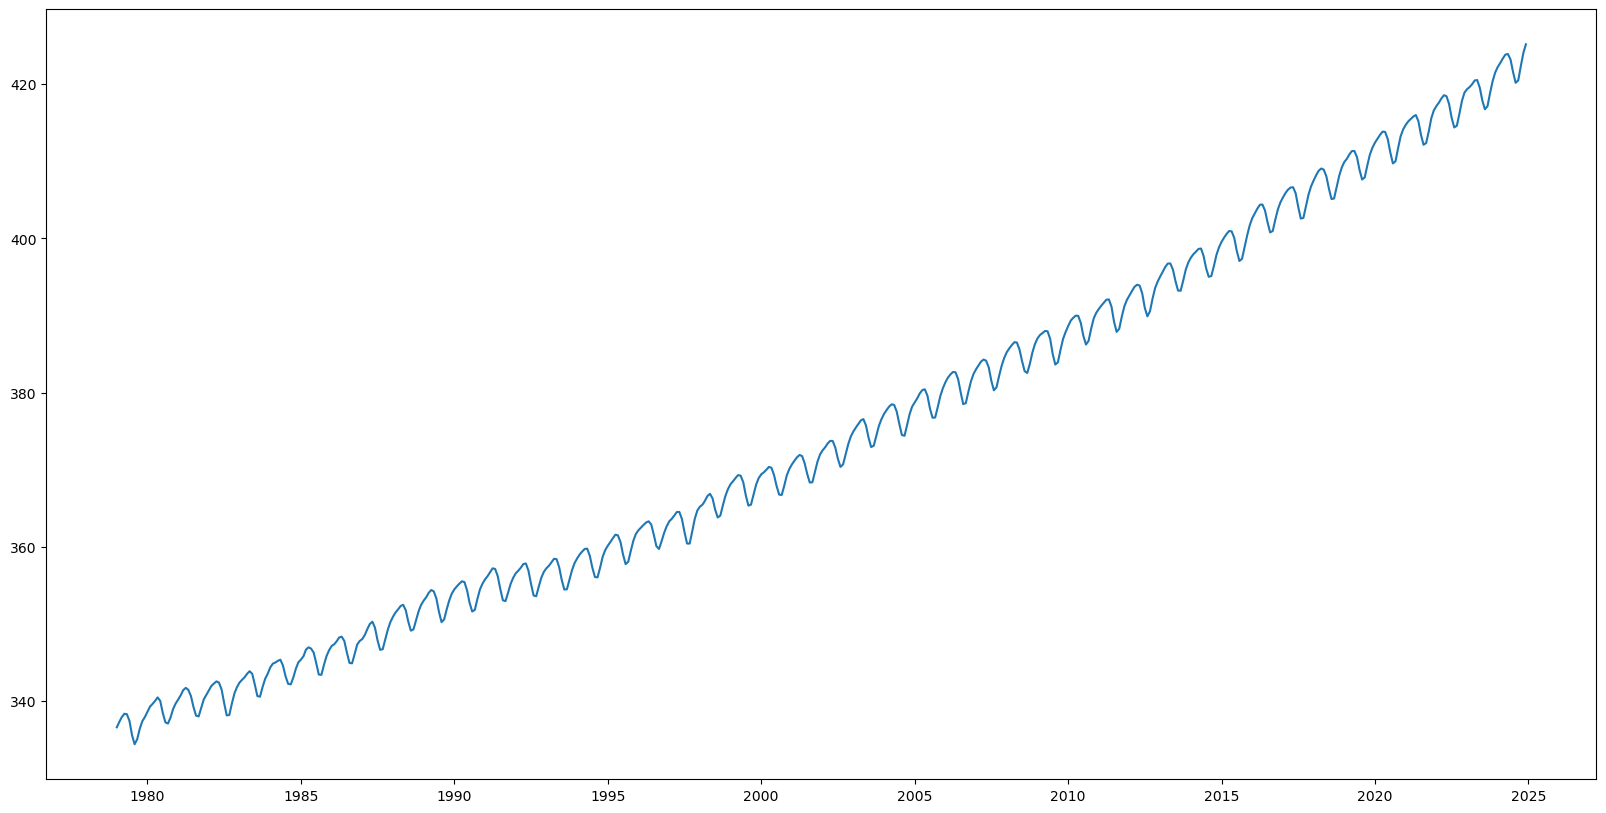

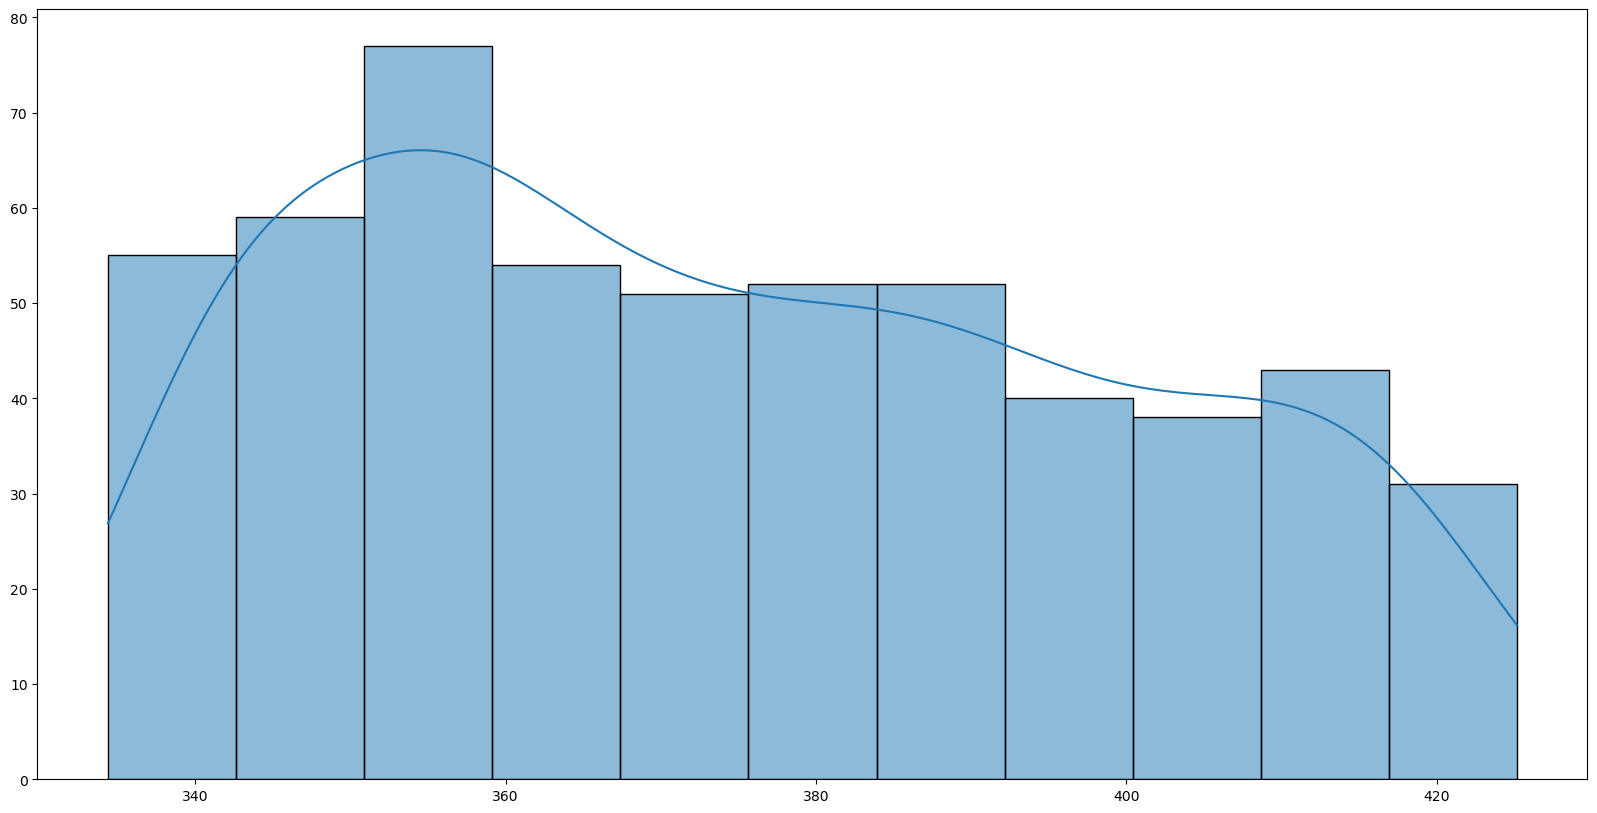

In [473]:
plotLine(data_set)
plotHistogram(data_set)

##### Decomposition

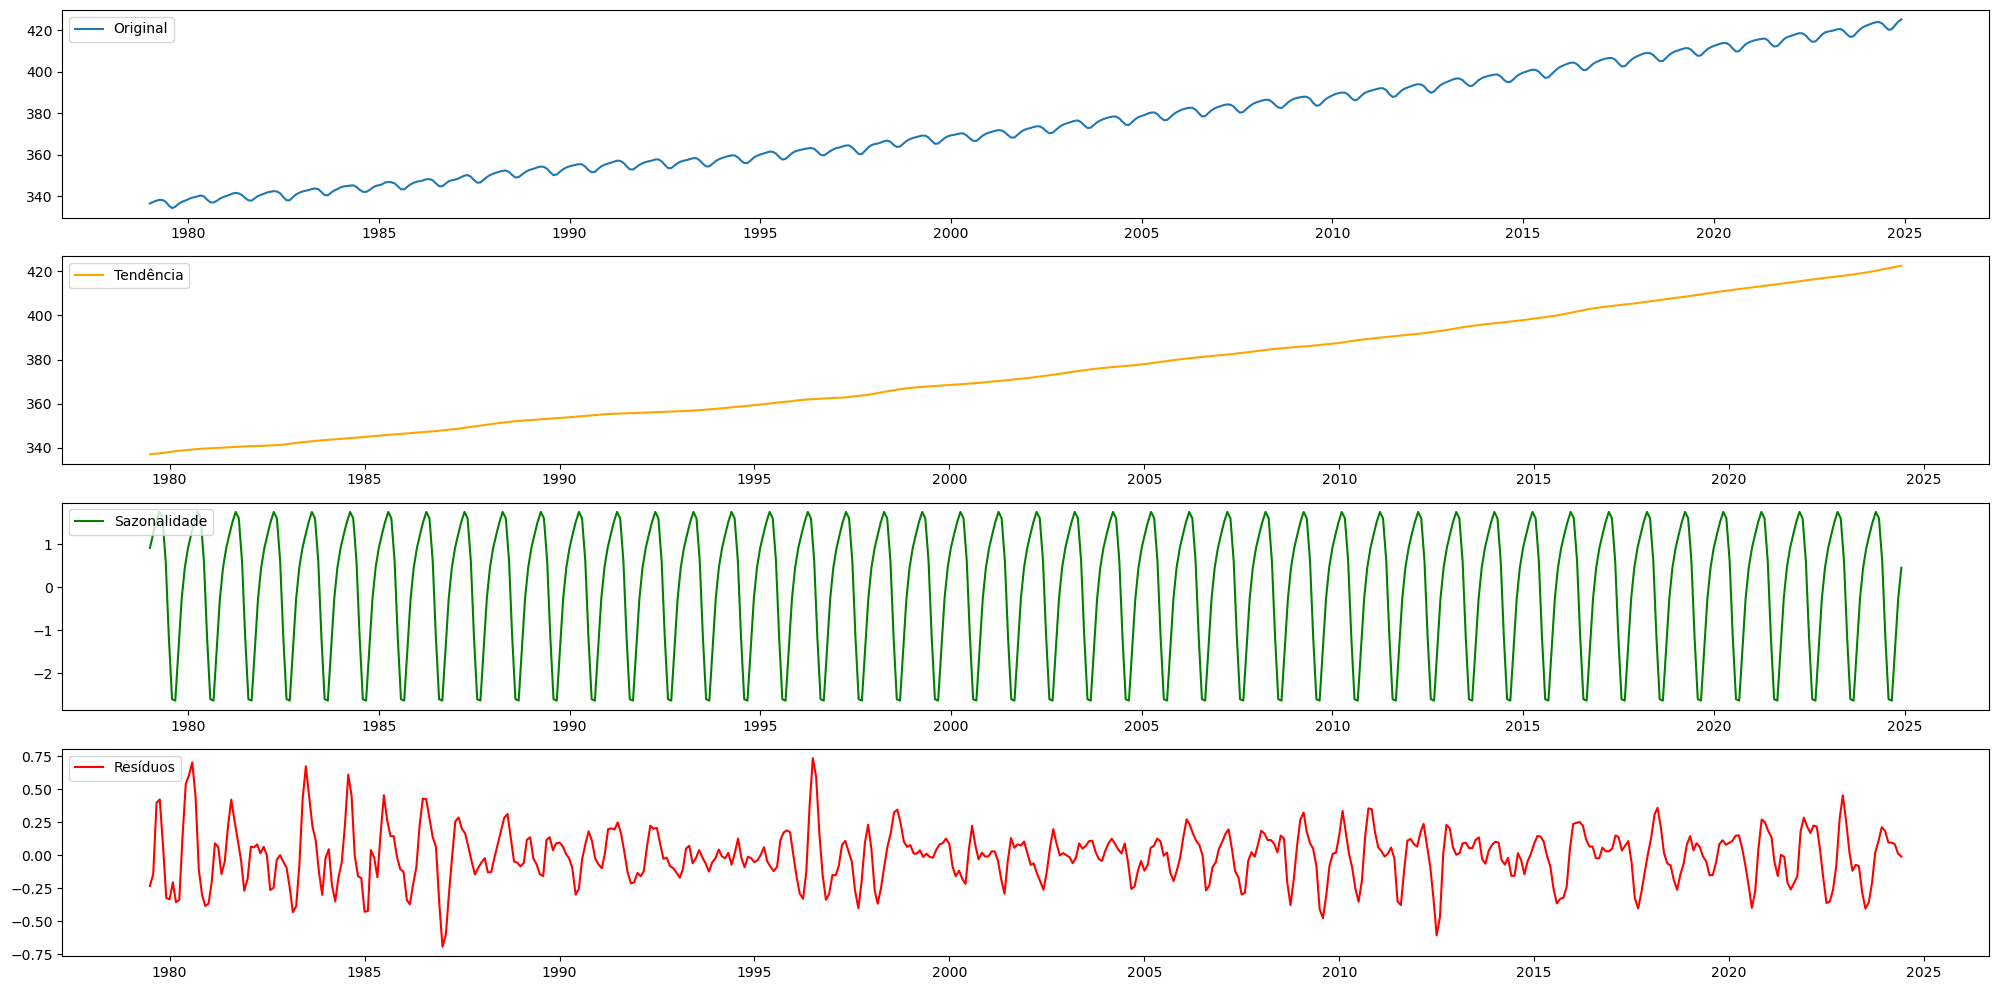

In [474]:
plotDecomposicao(data_set)

Com estes gr√°ficos percebo:
-   N√£o h√° outliers
-   Tend√™ncia bem definida linear
-   comportamento ciclico

##### PACF & ACF

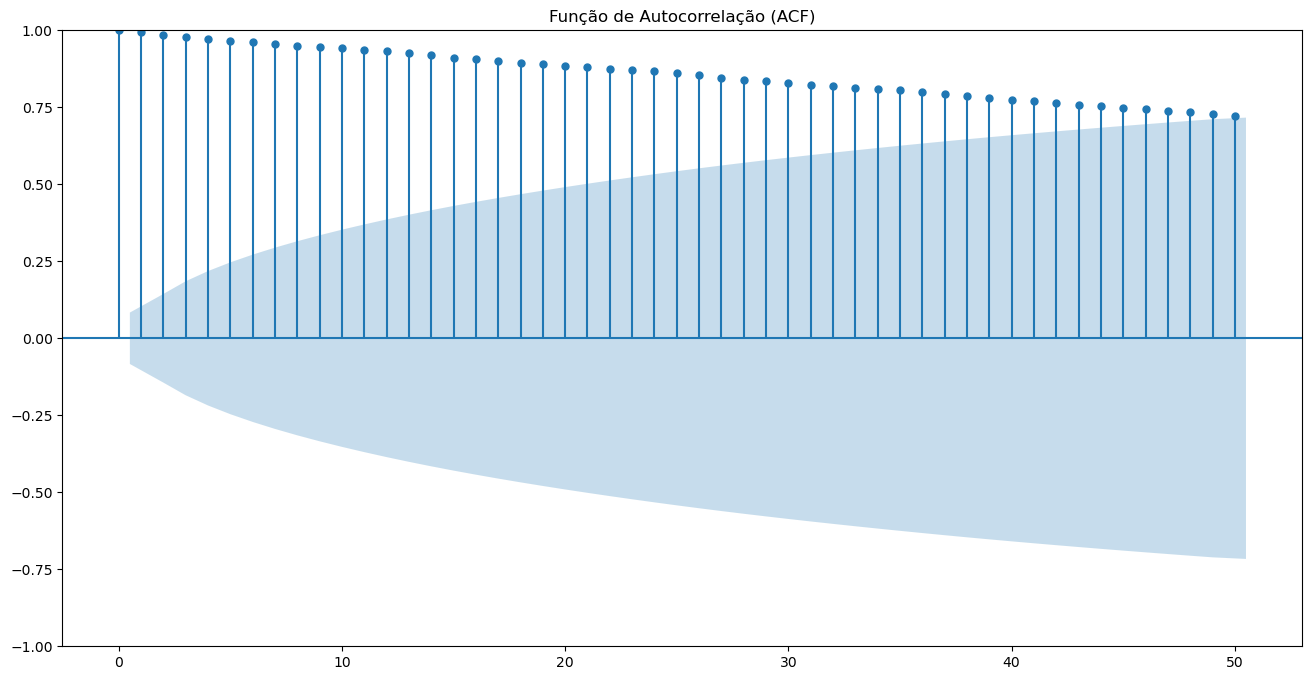

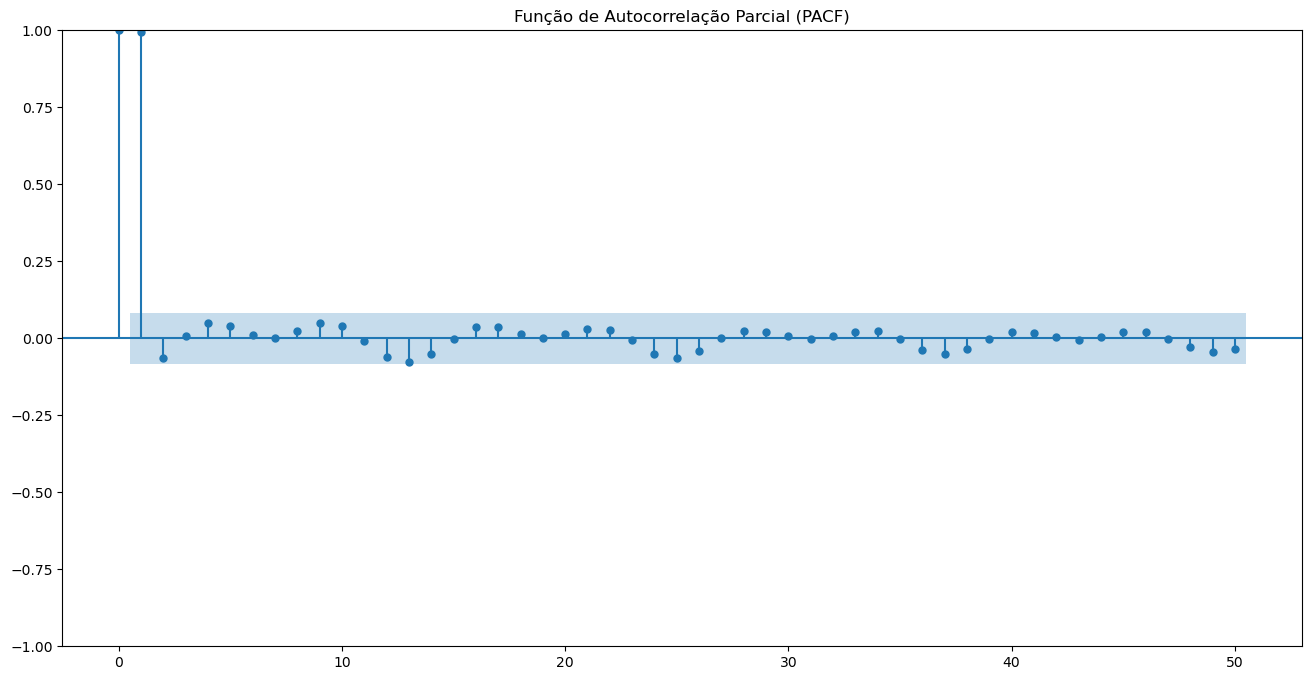

In [475]:
plotAutoCorrelation(data_set)
plotPartialAutoCorrelation(data_set)

#### An√°lise estat√≠stica

In [476]:
adfullerTest(data_set)
andersonTest(data_set)
kolmogorovTest(data_set)

Estat√≠stica do teste ADF: 4.648385021622469
Valor-p: 1.0000000000000000
Valores cr√≠ticos:
   1%: -3.442701754304053
   5%: -2.866988120523906
   10%: -2.5696716542766693
A s√©rie n√£o √© estacion√°ria.

Teste de Anderson-Darling
Estat√≠stica: 7.42896891
Valores Cr√≠ticos: ['0.57200000', '0.65100000', '0.78100000', '0.91100000', '1.08400000']
N√≠veis de Signific√¢ncia: [15.  10.   5.   2.5  1. ]
Para um n√≠vel de signific√¢ncia de 15.0%, rejeita a hip√≥tese nula (os dados n√£o seguem uma distribui√ß√£o normal)
Para um n√≠vel de signific√¢ncia de 10.0%, rejeita a hip√≥tese nula (os dados n√£o seguem uma distribui√ß√£o normal)
Para um n√≠vel de signific√¢ncia de 5.0%, rejeita a hip√≥tese nula (os dados n√£o seguem uma distribui√ß√£o normal)
Para um n√≠vel de signific√¢ncia de 2.5%, rejeita a hip√≥tese nula (os dados n√£o seguem uma distribui√ß√£o normal)
Para um n√≠vel de signific√¢ncia de 1.0%, rejeita a hip√≥tese nula (os dados n√£o seguem uma distribui√ß√£o normal)

Teste de Kolmogor

In [477]:
a = detectar_outliers_iqr(data_set)
a_list = []
for valor in a:
    if valor == True:
        a_list.append(valor)

print(a_list)

[]


In [478]:
b = detectar_outliers_zscore(data_set)

b_list = []
for valor in b:
    if valor == True:
        b_list.append(valor)

print(b_list)

[]


## Transforma√ß√µes

**Separa√ß√£o dos dados**

In [748]:
# Calcula o √≠ndice de corte
test_cut = int(len(data_set) * 0.6)
validation_cut = int(len(data_set) * 0.8)

# Divide a s√©rie em treino e teste
train = data_set.iloc[:test_cut]
test = data_set.iloc[test_cut:validation_cut]
validation = data_set.iloc[validation_cut:]

### Diferencia√ß√£o

380.07


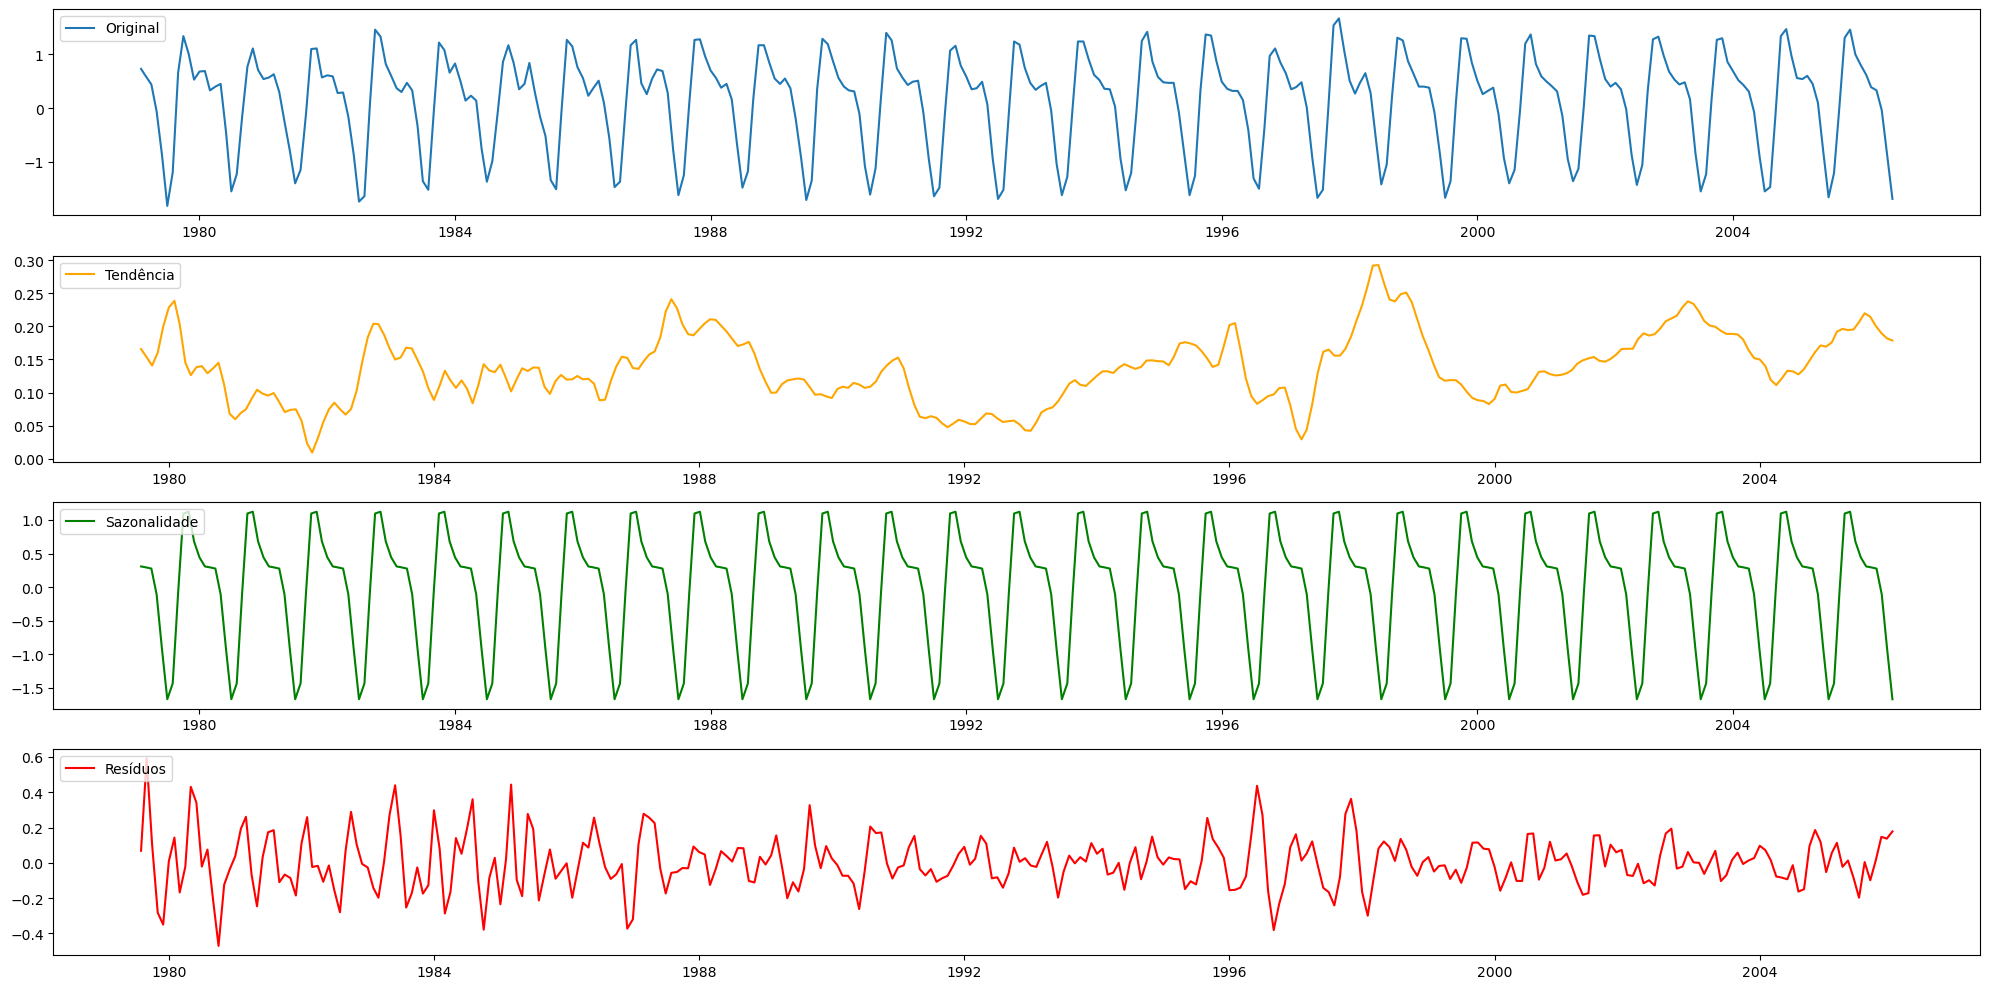

In [749]:
first_value = train.iloc[-1]
diff_data = train.diff().dropna()

print (first_value)
plotDecomposicao(diff_data)

##### Estat√≠sticas

Estat√≠stica do teste ADF: -3.7786148363428684
Valor-p: 0.0031338499555986
Valores cr√≠ticos:
   1%: -3.4514843502727306
   5%: -2.8708485956333556
   10%: -2.571729625657462
A s√©rie n√£o √© estacion√°ria.

Teste de Anderson-Darling
Estat√≠stica: 10.01825396
Valores Cr√≠ticos: ['0.56900000', '0.64800000', '0.77800000', '0.90700000', '1.07900000']
N√≠veis de Signific√¢ncia: [15.  10.   5.   2.5  1. ]
Para um n√≠vel de signific√¢ncia de 15.0%, rejeita a hip√≥tese nula (os dados n√£o seguem uma distribui√ß√£o normal)
Para um n√≠vel de signific√¢ncia de 10.0%, rejeita a hip√≥tese nula (os dados n√£o seguem uma distribui√ß√£o normal)
Para um n√≠vel de signific√¢ncia de 5.0%, rejeita a hip√≥tese nula (os dados n√£o seguem uma distribui√ß√£o normal)
Para um n√≠vel de signific√¢ncia de 2.5%, rejeita a hip√≥tese nula (os dados n√£o seguem uma distribui√ß√£o normal)
Para um n√≠vel de signific√¢ncia de 1.0%, rejeita a hip√≥tese nula (os dados n√£o seguem uma distribui√ß√£o normal)

Teste de Kolm

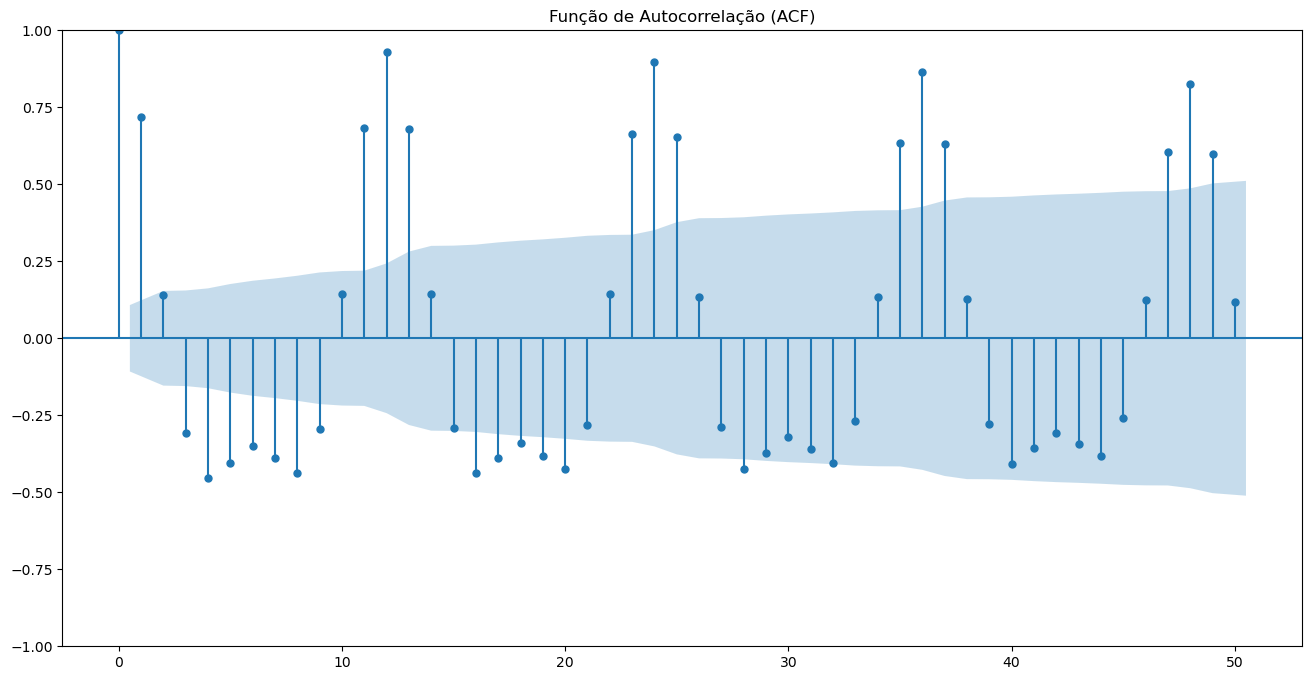

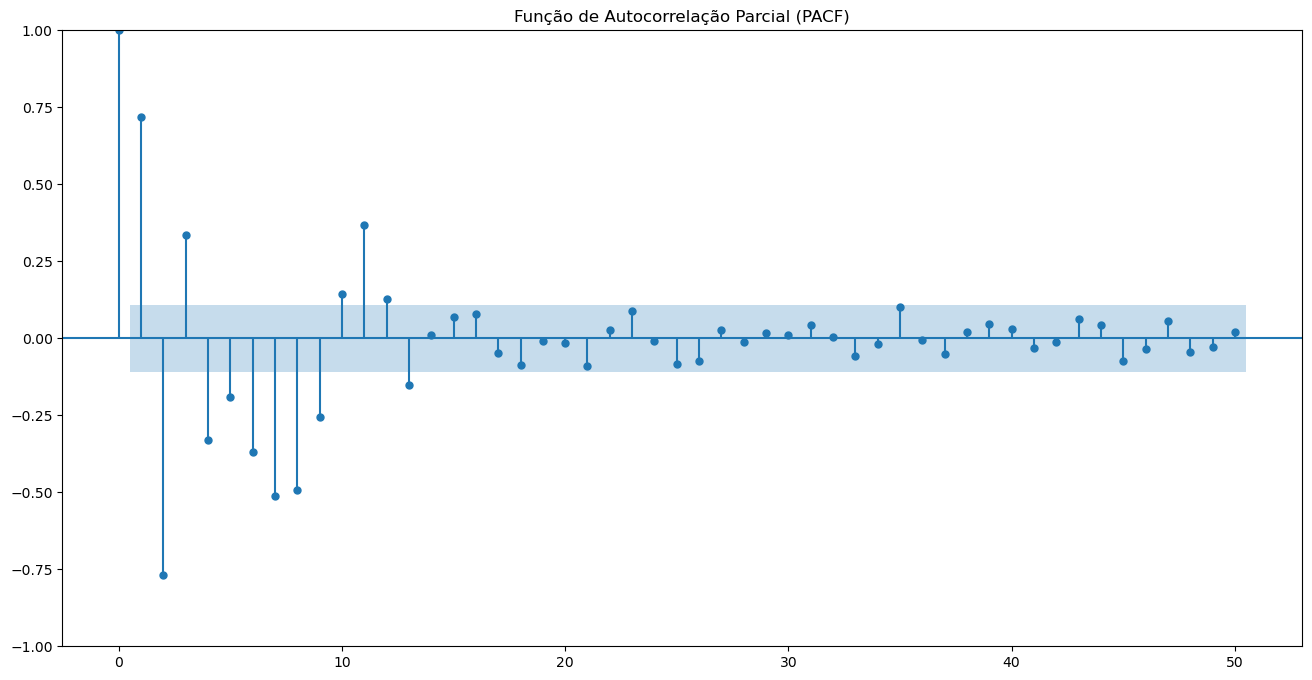

In [750]:
adfullerTest(diff_data)
andersonTest(diff_data)
kolmogorovTest(diff_data)
plotAutoCorrelation(diff_data)
plotPartialAutoCorrelation(diff_data)

#### Testando uma segunda diferencia√ß√£o

In [751]:
# first_value2 = diff_data.iloc[0]
# diff_data = diff_data.diff().dropna()

# plotDecomposicao(diff_data)

# adfullerTest(diff_data)
# andersonTest(diff_data)
# kolmogorovTest(diff_data)
# plotAutoCorrelation(diff_data)
# plotPartialAutoCorrelation(diff_data)

## Predi√ß√£o

### SARIMAX

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


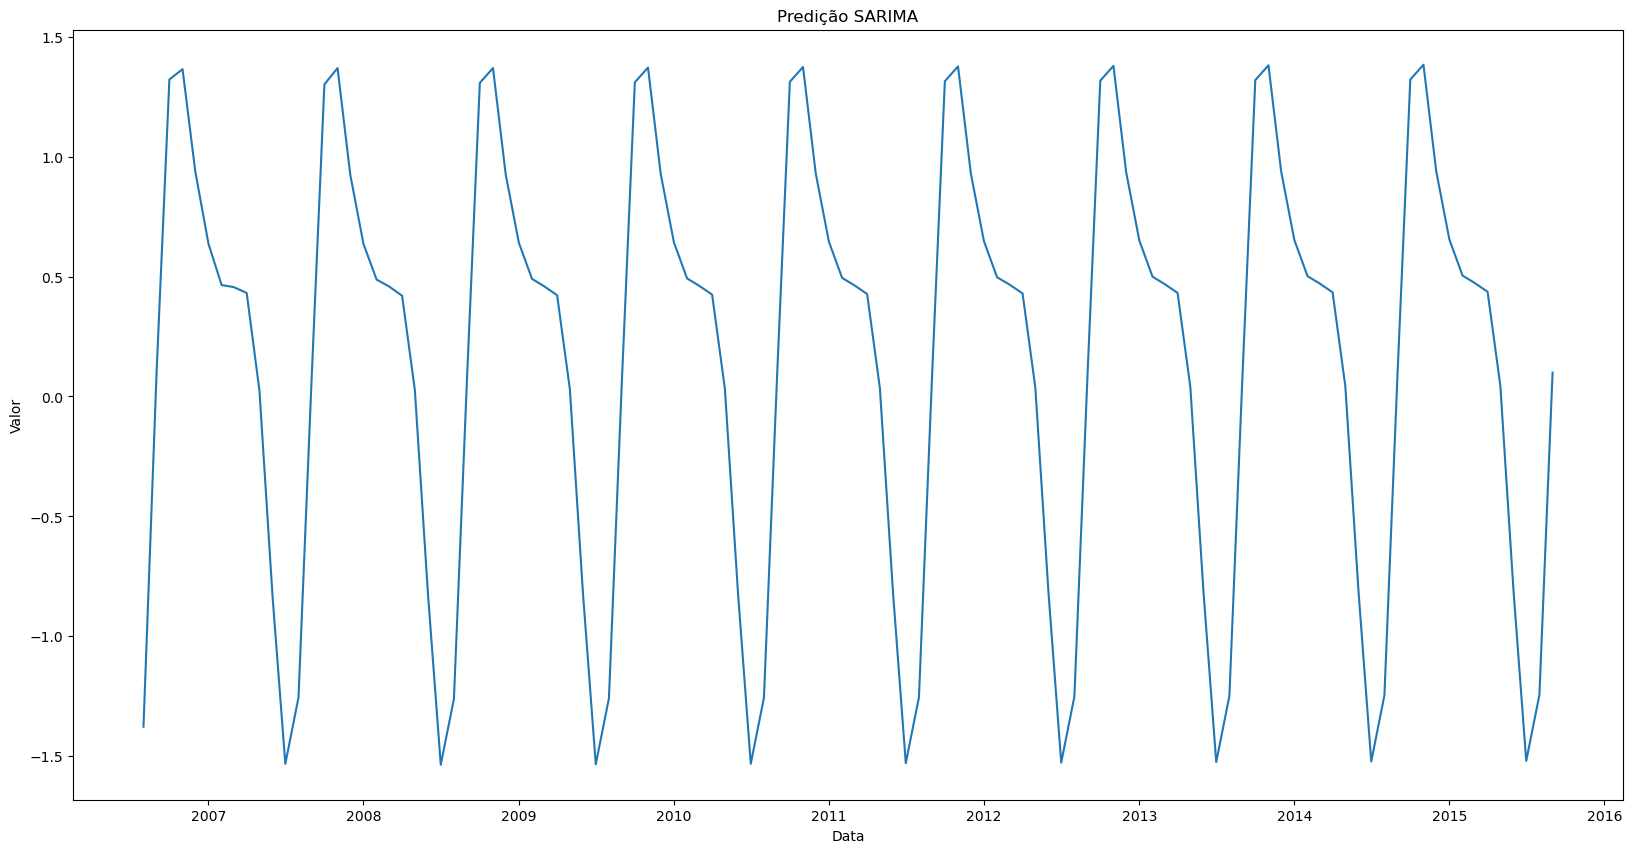

In [ ]:
predicaoSarima = SARIMAX(diff_data, order=(3, 1, 9), seasonal_order=(1, 1, 1, 12)).fit()
predicao = predicaoSarima.forecast(steps=len(test))

plotLine(predicao, title='Predi√ß√£o SARIMA', xlabel='Data', ylabel='Valor')

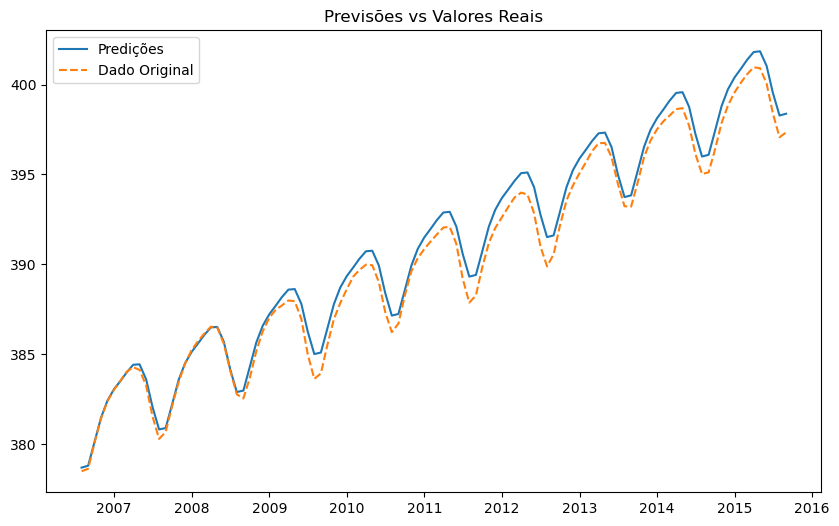

In [758]:
revert_diff = np.cumsum(predicao) + first_value


plt.figure(figsize=(10, 6))
# plt.plot(revertDiffPredicao, label="Predi√ß√µes")
plt.plot(revert_diff, label="Predi√ß√µes")
plt.plot(test, label="Dado Original", linestyle="--")
plt.title("Previs√µes vs Valores Reais")
plt.legend()
plt.show()

  üîπ R¬≤ (Coeficiente de Determina√ß√£o): ------------ 0.9813
  üîπ RMSE (Raiz Quadrada do Erro Quadr√°tico M√©dio): 0.7860
  üîπ MAE (Erro Absoluto M√©dio): ------------------- 0.6780
  üîπ MAPE (Erro Percentual Absoluto): ------------- 0.1730%
  üîπ Acur√°cia: ------------------------------------ 99.8270%


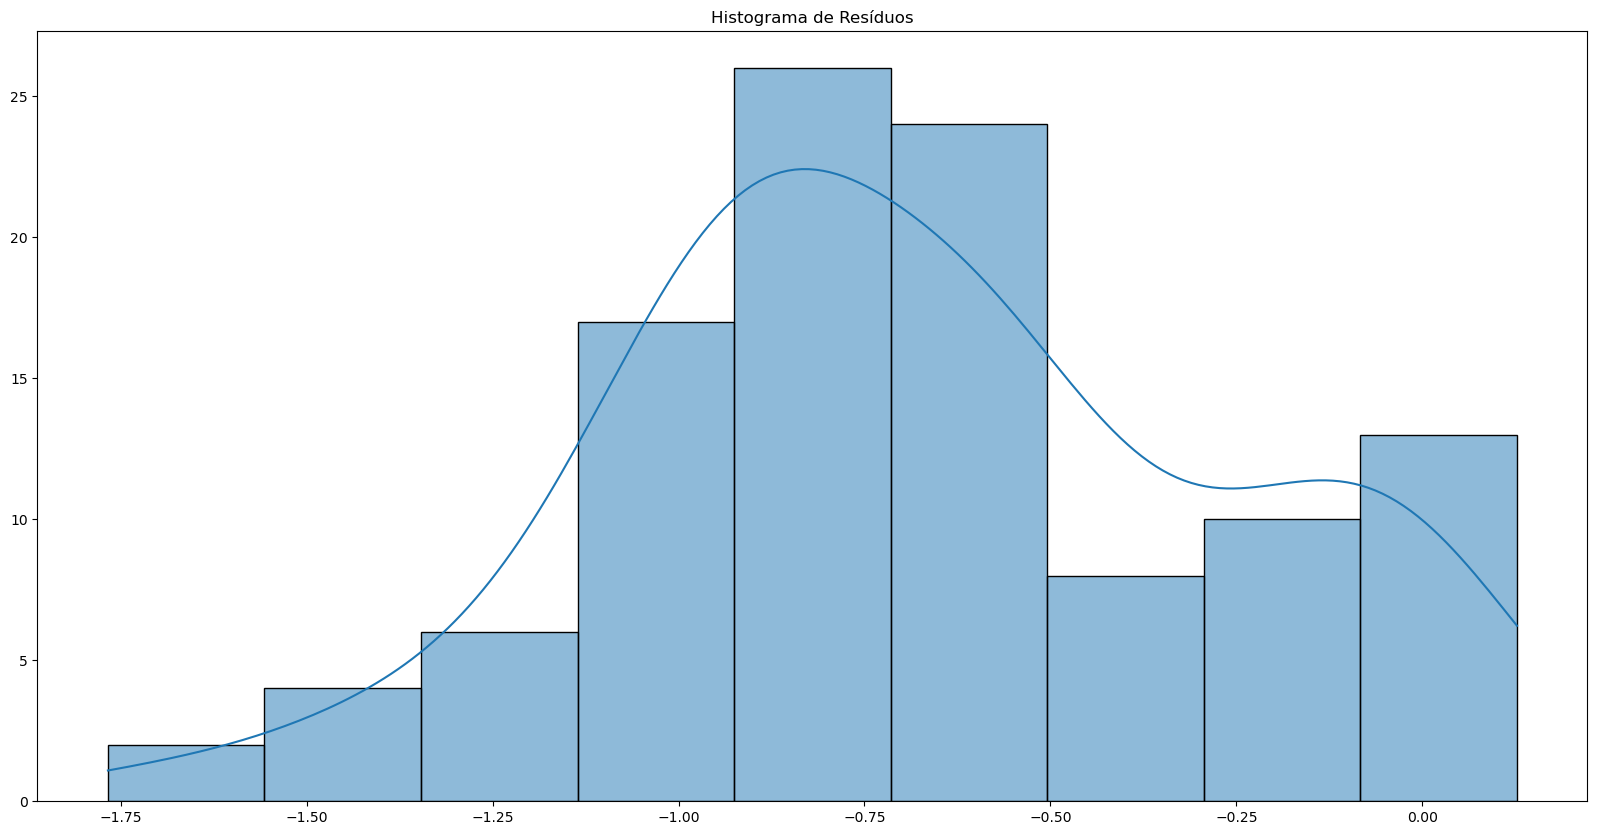

In [759]:
dataParaComparativo = test.dropna()
dataPredicaoTratada = revert_diff.dropna()

dataParaComparativo = dataParaComparativo[:dataPredicaoTratada.size]
dataPredicaoTratada = dataPredicaoTratada[:dataParaComparativo.size]

def mean_absolute_percentage_error(y_true, y_pred):
    mask = y_true != 0  # Evitar divis√£o por zero
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

# Calcular m√©tricas
# f1 = f1_score(dataParaComparativo, dataPredicaoTratada)
r2 = r2_score(dataParaComparativo, dataPredicaoTratada)
rmse = np.sqrt(mean_squared_error(dataParaComparativo, dataPredicaoTratada))
mae = mean_absolute_error(dataParaComparativo, dataPredicaoTratada)
mape = mean_absolute_percentage_error(dataParaComparativo.values, dataPredicaoTratada.values)
accuracy = 100 - mape

# print(f"  üîπ R¬≤ (Coeficiente de Determina√ß√£o): {f1:.2f}") #Fun√ß√£o criada para teste, entretanto n√£o foi possivel aplicar aqui
print(f"  üîπ R¬≤ (Coeficiente de Determina√ß√£o): ------------ {r2:.4f}")
print(f"  üîπ RMSE (Raiz Quadrada do Erro Quadr√°tico M√©dio): {rmse:.4f}")
print(f"  üîπ MAE (Erro Absoluto M√©dio): ------------------- {mae:.4f}")
print(f"  üîπ MAPE (Erro Percentual Absoluto): ------------- {mape:.4f}%")
print(f"  üîπ Acur√°cia: ------------------------------------ {accuracy:.4f}%")

plotHistogram(np.array(dataParaComparativo) - np.array(dataPredicaoTratada), title="Histograma de Res√≠duos")

### Auto-Arima

In [760]:
# def auto_arima(data: pd.Series, m: int = 12):
#     model = pm.auto_arima(data.dropna(),
#                         seasonal=True,
#                         m=m,
#                         trace=True,
#                         error_action='ignore',
#                         suppress_warnings=True,
#                         stepwise=True
#                         )
#     print(model.summary())

In [761]:
# auto_arima(diff_data)